<img src="https://i.imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px;"/>


# DSI-SG-42

## Project Two - Regression Challenge (HDB Price)

---
## Context
Anchoring bias affects home prices by setting a psychological benchmark that influences buyers' and sellers' expectations. When a seller lists a home at a certain price, that price can become an anchor, shaping negotiations and final sale prices. Buyers may compare other properties to this anchor, affecting their willingness to pay. Similarly, a high initial offer can anchor the seller's expectations, potentially leading to a higher final sale price. This bias can lead to overvaluation or undervaluation of homes based on the initial price set, rather than their actual market value​​.

Source: https://www.channelnewsasia.com/singapore/record-high-hdb-resale-price-q3-2021-2215726


---

## Problem Statement

How can we effectively assess a property’s value with factors other than historical price?

## Audience
For couples who have decided to look into the resale market who are seeking a shorter waiting, not able to wait for build-to-order flats, seeking to downgrade or upgrade. 


# 1.1 Data Cleaning

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# setting displays
%matplotlib inline
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# handle warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# import train data
hdb_raw = pd.read_csv('../datasets/train.csv', low_memory=False)

print(hdb_raw.head()) # Dtype warning on 'postal' column

       id Tranc_YearMonth             town  flat_type block       street_name storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  Tranc_Year  Tranc_Month  mid_storey  lower  upper  mid       full_flat_type               address  floor_area_sqft  price_per_sqft  hdb_age  max_floor_lvl  year_completed residential commercial market_hawker multistorey_carpark precinct_pavilion  total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  2room_rental  3room_rental  other_room_rental  postal  Latitude   Longitude planning_area  Mall_Nearest_Distance  Mall_Within_500m  Mall_Within_1km  Mall_Within_2km  Hawker_Nearest_Distance  Hawker_Within_500m  Hawker_Within_1km  Hawker_Within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance     mrt_name  bus_interchange  mrt_interchange  mrt_latitude  mrt_longitude  bus_stop_nearest_distance             bus_stop_name  bus_stop_la

In [5]:
hdb_raw['postal'] = hdb_raw['postal'].astype(object) # convert 'postal' column to object

# clean up column names
hdb_raw.columns = hdb_raw.columns.str.strip() # remove whitespace
hdb_raw.columns = hdb_raw.columns.str.lower() # lowercase headers


print(hdb_raw.columns) # inspect columns

Index(['id', 'tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price', 'tranc_year', 'tranc_month', 'mid_storey', 'lower', 'upper', 'mid', 'full_flat_type', 'address', 'floor_area_sqft', 'price_per_sqft', 'hdb_age', 'max_floor_lvl', 'year_completed', 'residential', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental', 'other_room_rental', 'postal', 'latitude', 'longitude', 'planning_area', 'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name', 'bus_interchange', 'mrt_interchange', 'm

In [6]:
# Inspect features with boolean values if there are truly binary

columns_boolean = ['residential', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation']

# inspect boolean columns
for col in columns_boolean:
    print(hdb_raw[col].value_counts())
    

residential
Y    150634
Name: count, dtype: int64
commercial
N    121815
Y     28819
Name: count, dtype: int64
market_hawker
N    150619
Y        15
Name: count, dtype: int64
multistorey_carpark
N    150592
Y        42
Name: count, dtype: int64
precinct_pavilion
N    150499
Y       135
Name: count, dtype: int64
bus_interchange
1    82301
0    68333
Name: count, dtype: int64
mrt_interchange
0    110863
1     39771
Name: count, dtype: int64
pri_sch_affiliation
0    133583
1     17051
Name: count, dtype: int64
affiliation
0    145832
1      4802
Name: count, dtype: int64


Based on the columns that should contain boolean values, 'residential' column only contains 'Y' and can be dropped as it would not contribute to the modeling. 

Columns that contain 'commercial', 'market_hawker', 'multistorey_carpark', and 'precinct_pavilion' can have the values changed to Y=1, N=0. The remaining columns can retain their values. 

In [7]:
# drop 'residential column' as there is only one value
# drop 'floor_area_sqm' as it is the same but different units to 'floor_area_sqft'
hdb_raw = hdb_raw.drop(columns = ['residential', 'floor_area_sqft'], axis = 1)

# convert columns to appropriate datatype

# convert id to object
hdb_raw['id'] = hdb_raw['id'].astype(object)

# convert tranc_year as int
hdb_raw['tranc_year'] = hdb_raw['tranc_year'].astype(int)

# convert all boolean integer values 
yes_no = ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
hdb_raw[yes_no] = hdb_raw[yes_no].stack().map({'Y': 1, 'N': 0}).unstack()

# inspect boolean values
#print(hdb_raw.head())  # debug

In [8]:
# understanding what some of the columns are

#print(hdb_raw['town'].value_counts()) # 26 townships
#print(hdb_raw['flat_type'].value_counts()) # 6 room types
#print(hdb_raw['flat_model'].value_counts()) # 20 flat models
#print(hdb_raw['storey_range'].value_counts()) # 25 ranges
#print(hdb_raw['tranc_year'].value_counts()) # 10 transaction years - transactions that took place


In [9]:
# Cleaning up some column headers

hdb_raw = hdb_raw.rename(columns = {'1room_sold': 'one_room_unit',
                                '2room_sold': 'two_room_unit',
                                '3room_sold': 'three_room_unit',
                                '4room_sold': 'four_room_unit',
                                '5room_sold': 'five_room_unit',
                                'exec_sold': 'exec_unit',
                                'multigen_sold': 'multigen_unit',
                                'studio_apartment_sold': 'studio_apartment',
                                '1room_rental': 'one_room_rental',
                                '2room_rental': 'two_room_rental',
                                '3room_rental': 'three_room_rental'
                                })


# check that the column names has been changed
print(hdb_raw.columns) # debug

Index(['id', 'tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price', 'tranc_year', 'tranc_month', 'mid_storey', 'lower', 'upper', 'mid', 'full_flat_type', 'address', 'price_per_sqft', 'hdb_age', 'max_floor_lvl', 'year_completed', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'total_dwelling_units', 'one_room_unit', 'two_room_unit', 'three_room_unit', 'four_room_unit', 'five_room_unit', 'exec_unit', 'multigen_unit', 'studio_apartment', 'one_room_rental', 'two_room_rental', 'three_room_rental', 'other_room_rental', 'postal', 'latitude', 'longitude', 'planning_area', 'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name', 'bus_interchange', 'mrt_interchange', 'mrt_latitu

In [10]:
# checking which columns have null values and count the number of null

hdb_raw.loc[:, hdb_raw.isna().any()].isna().sum()

mall_nearest_distance      829
mall_within_500m         92789
mall_within_1km          25426
mall_within_2km           1940
hawker_within_500m       97390
hawker_within_1km        60868
hawker_within_2km        29202
dtype: int64

In [11]:
# since hawker and mall distance intervals are the number of hawker/malls within that distance we can
# convert hawker and mall distances to int type 
malls_hawkers = ['mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_within_500m', 'hawker_within_1km','hawker_within_2km']

hdb_raw = hdb_raw.fillna(0) # assume that there is no mall or hawker for resale flats that has NaN values

hdb_raw[malls_hawkers] = hdb_raw[malls_hawkers].astype(int) # convert to integer type

# check which columns have null values and count the number of null again

hdb_raw.loc[:, hdb_raw.isna().any()].isna().sum()

Series([], dtype: float64)

There do not seem to be any null values in the dataframe after filling null values.

In [12]:
# divide dataframe between numerical and categorical datasets

# numerical
hdb_numerical = [x for x in hdb_raw if hdb_raw[x].dtype != object]
hdb_numerical = hdb_raw[hdb_numerical]


# categorical values
hdb_categorical = [x for x in hdb_raw if hdb_raw[x].dtype == object]
hdb_categorical = hdb_raw[hdb_categorical]

# check to see if the split dataframe of numerical and categorical total to the main dataframe

print(hdb_raw.shape) # 76 columns
print(len(hdb_numerical.columns) + len(hdb_categorical.columns)) # total 76 columns

(150634, 76)
76


## 1.2 Exploratory Data Analysis

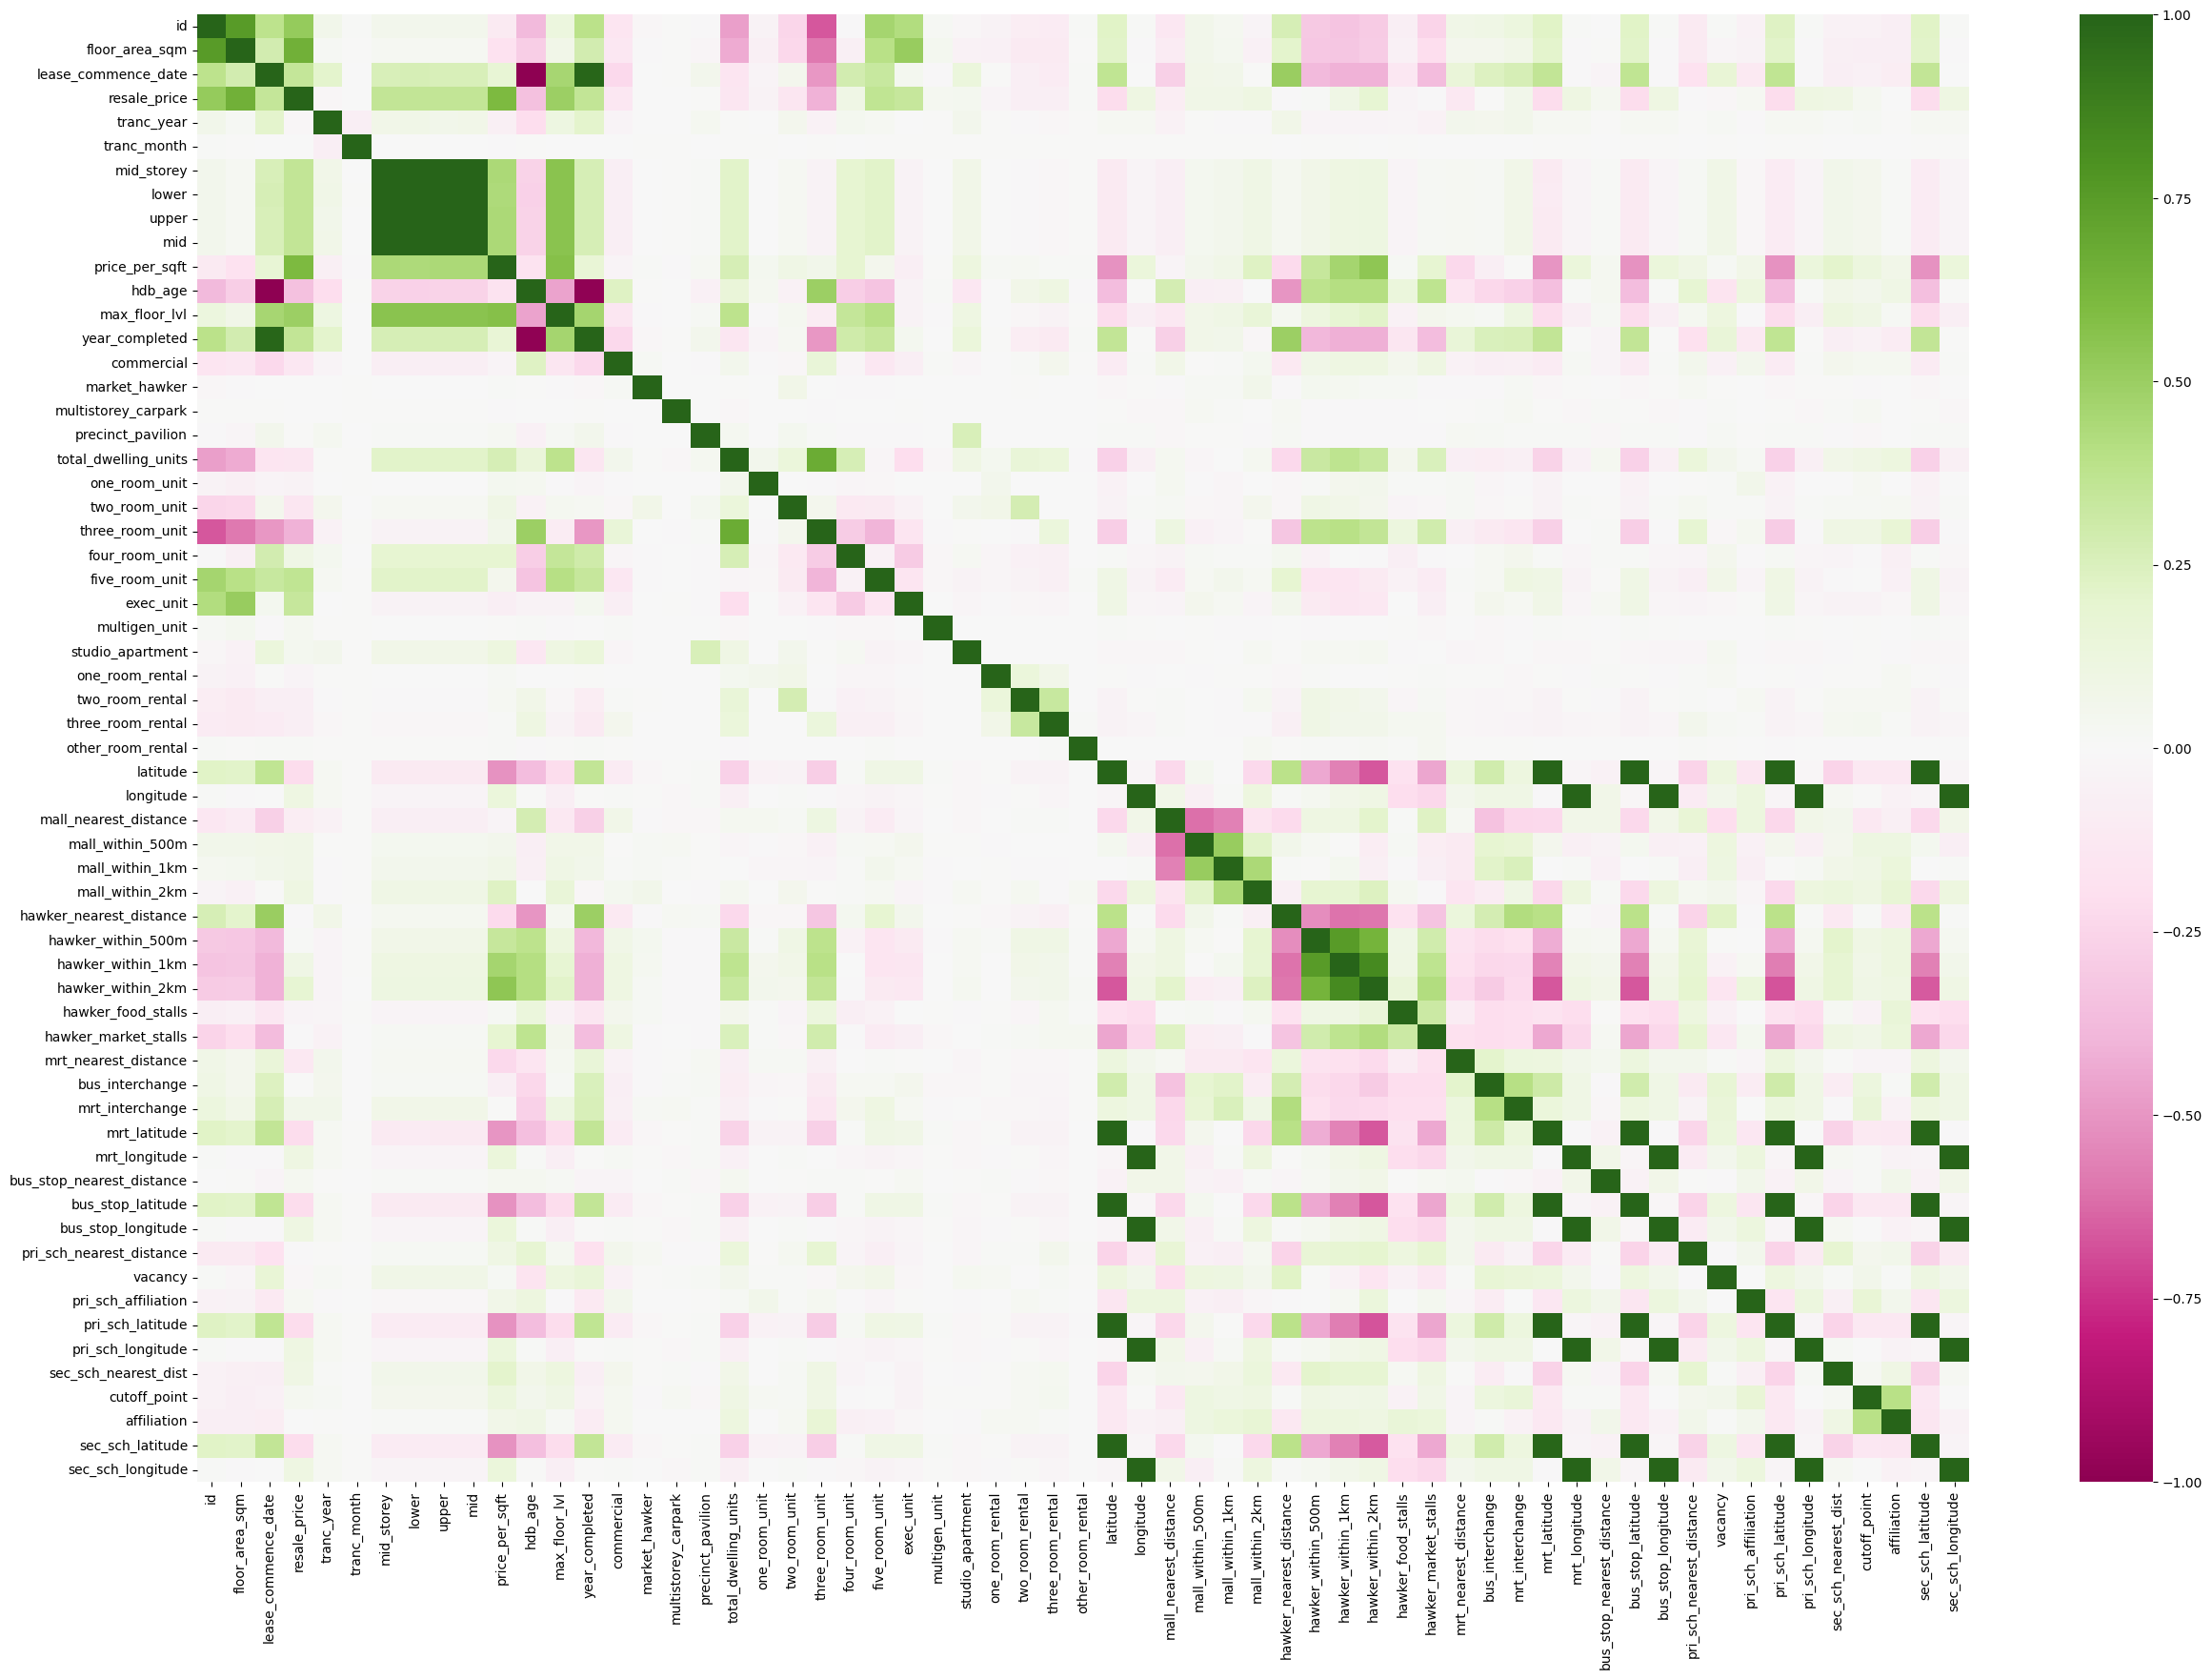

In [13]:
# plot a heat map
plt.figure(figsize=(30,20))

hdb_heatmap = hdb_numerical.corr()

sns.heatmap(hdb_heatmap, cmap='PiYG')

plt.show()

From the heatmap, we can see multicollinearity among features as shown in the list below:

Perfect Positive Correlation
- any variables containing coordinates of latitude and longitude
- Year completed vs lease commence data
- any combinations of mid_storey, upper, lower, mid


Perfect Negative Correlation
- Lease commence date vs HDB age
- Year completed vs HDB age

Suspicious Correlations
- Hawker_within_2km vs (sec_sch_latitude or pri_sch_latitude or bus_stop_latitude or mrt_latitude, latitude)



The above list suggests that the correlations would need to be scrutinised and that there are collinearity among the variables. The suspicious correlations could just be a coincidence that the latitude is somewhat inversely correlated to the numbers in Hawker_within_2km. Singapore's latitude is around 1.3521 degrees N. The number of Hawker_within_2km goes upwards from 2km, hence, it is just by coincidence that there is an inverse correlation.



### Distribution of resale price and the median resale price

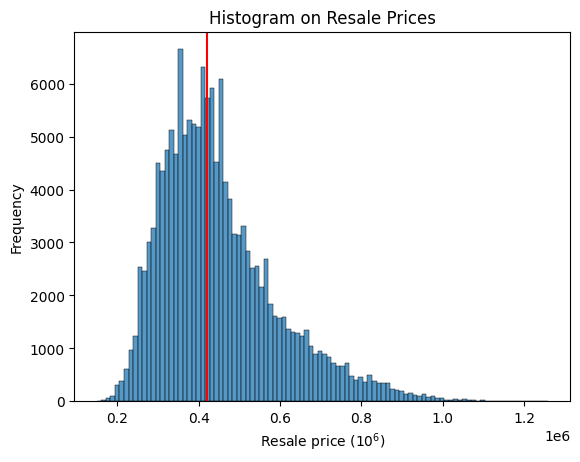

In [14]:
# Distribution of resale price and the median resale price

# median prices of resale units
median_resale_price = np.median(hdb_raw['resale_price'])
#print(median_resale_price) # 420000.0

# plotting histogram
sns.histplot(hdb_raw['resale_price'], bins = 100)

# adding plot information
plt.xlabel('Resale price ($10^6$)')
plt.ylabel('Frequency')
plt.title('Histogram on Resale Prices')

# insert vertical red line as median resale value
plt.axvline(420000, c='r')
plt.show()



From the histogram plot, the resale price of units sold from 2012 - 2021 is normally distributed with a positive tail. The median resale flats transacted of $420,000 is in the middle of the distribution while transactions of upward of 1.2 million dollars have occurred. 

### Distribution of median resale prices among the different planning areas

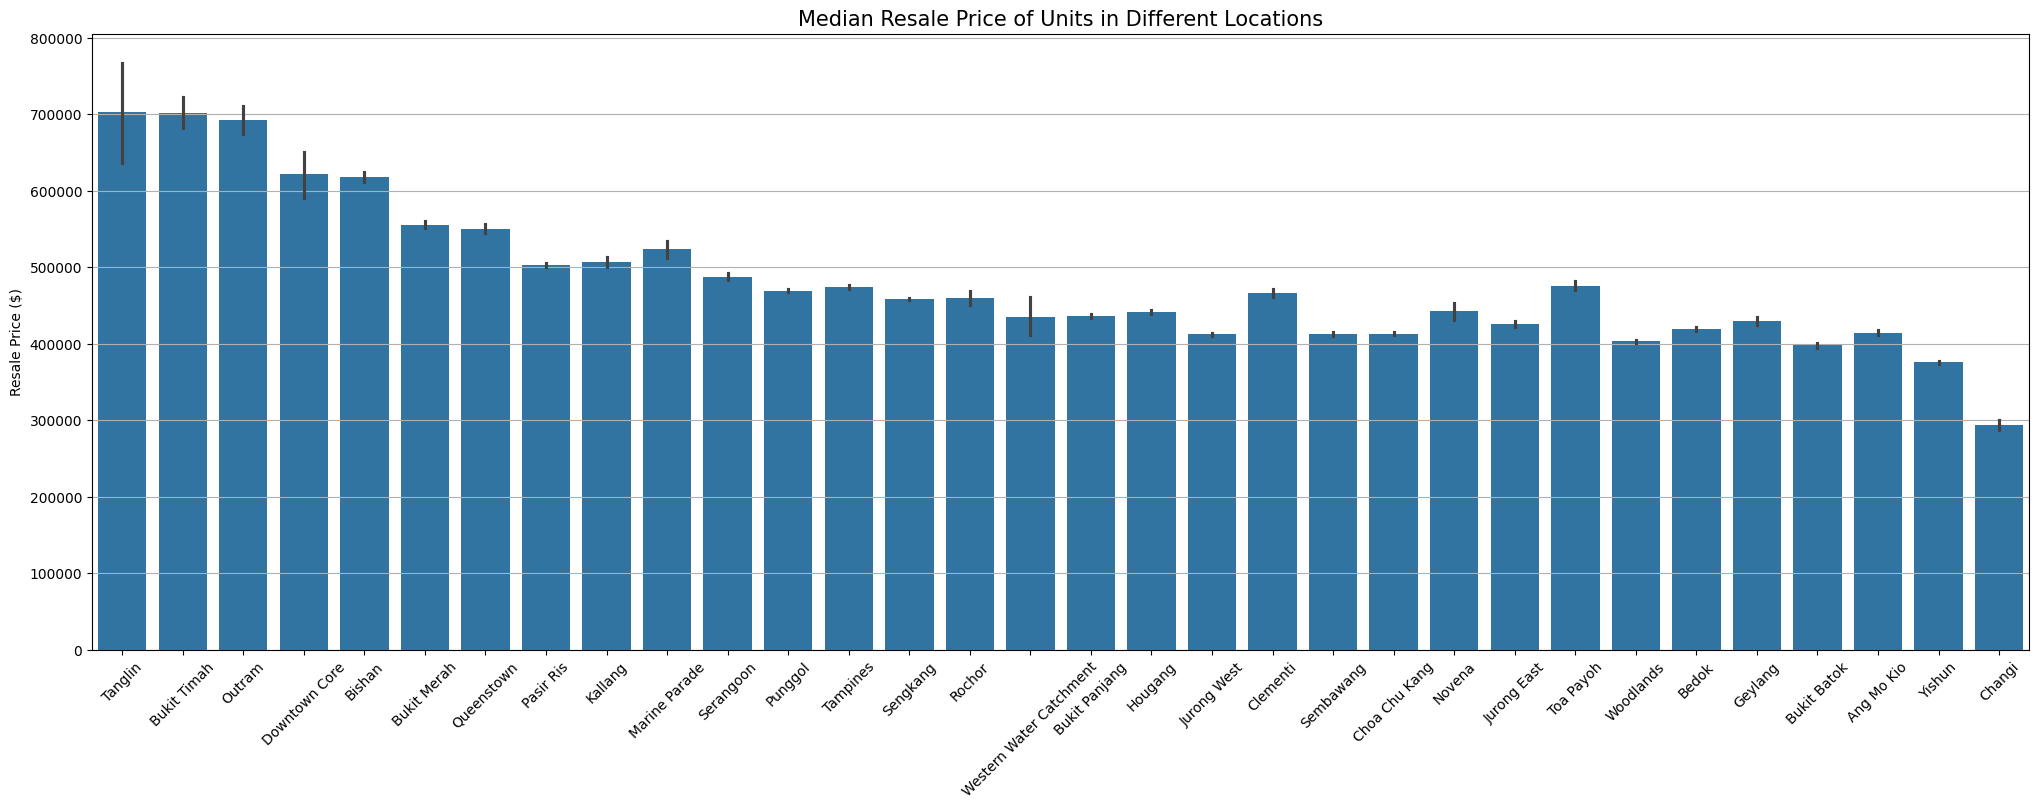

In [15]:
# plot distribution of median resale prices on different planning area based on URA's Master Plan
plt.figure(figsize=(25,8))

median_price_area = hdb_raw.groupby(['planning_area'])['resale_price'].median().sort_values(ascending=False)

# plotting of barplot
sns.barplot(x = hdb_raw['planning_area'], y = hdb_raw['resale_price'], order = median_price_area.index)

# adding graph information
plt.xlabel('')
plt.xticks(rotation = 45)
plt.ylabel('Resale Price ($)')
plt.title('Median Resale Price of Units in Different Locations', fontsize = 15)

plt.grid(axis = 'y')

plt.show()

The distribution graph shows the different median prices among the planning areas. The ranges of median prices are mostly consistent except Central locations and Western Water Catchment.

### Plot mean vs median resale prices among plannning areas

/var/folders/7t/2sjqtdp96wlfflldlvnvbm180000gn/T/ipykernel_50580/1989554940.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(mean_price_area.index, rotation = 45, ha='right')


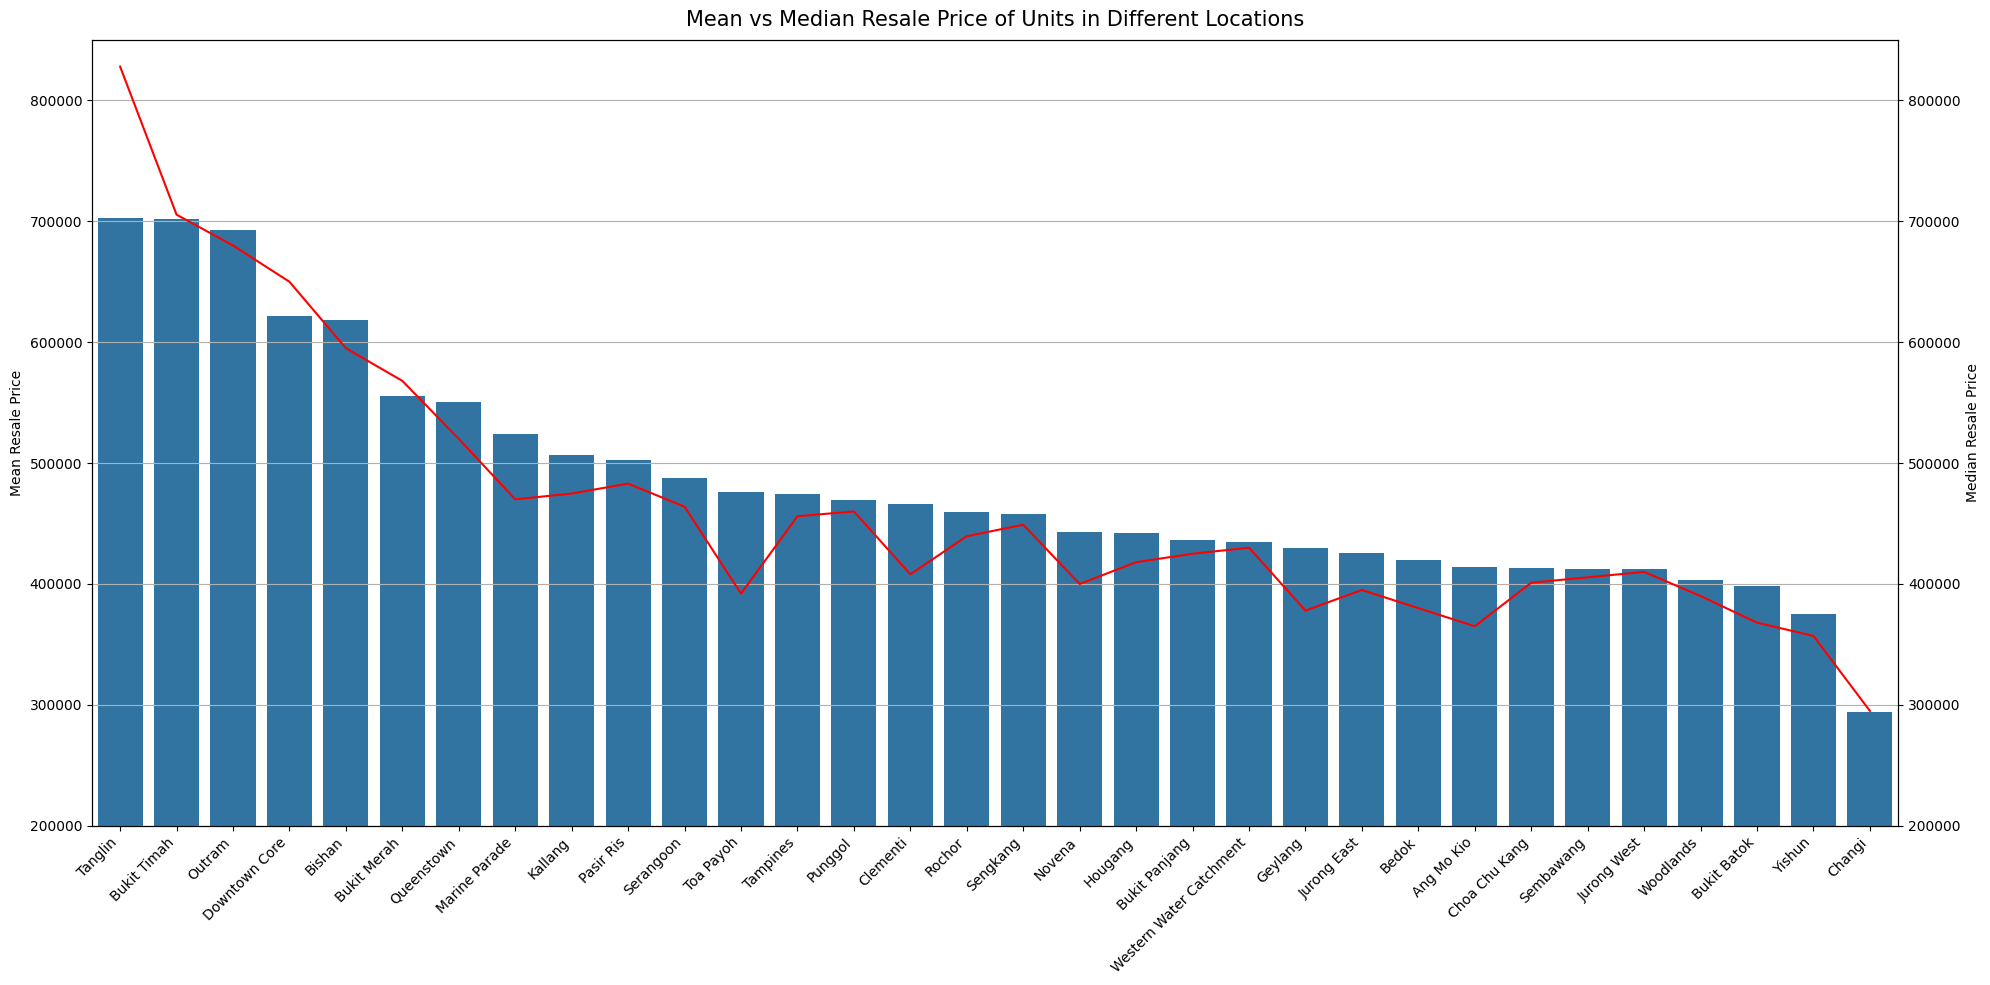

In [16]:
# plot distribution of mean resale prices on different planning area based on URA's Master Plan

fig, ax1 = plt.subplots(figsize=(20,10))

mean_price_area = hdb_raw.groupby(['planning_area'])['resale_price'].mean().sort_values(ascending=False)
median_resale_area = hdb_raw.groupby(['planning_area'])['resale_price'].median().sort_values(ascending=False)

# plotting of barplot
ax1 = sns.barplot(x = mean_price_area.index, y = mean_price_area.values)

ax1.set_xlim()
ax1.set_ylim(200000, 850000)
ax1.set_ylabel('Mean Resale Price')
ax1.set_xlabel('')
#ax1.set_xlabel('Planning Area')
#ax1.legend(loc='upper left')
ax1.set_xticklabels(mean_price_area.index, rotation = 45, ha='right')


ax2 = ax1.twinx()

ax2 = sns.lineplot(x = median_resale_area.index, y = median_resale_area.values, color = 'red')
ax2.set_ylim(200000, 850000)
ax2.set_ylabel('Median Resale Price')
ax2.set_xlabel('')

# adding graph information
plt.suptitle('Mean vs Median Resale Price of Units in Different Locations', fontsize = 15)
plt.grid()
plt.tight_layout()
plt.show()

The plot above shows how varied the use of mean and median statistics have on HDB resale flats. The use of median resale prices will be used as mean is easily influenced by outliers. 

### Distribution of resale units sold over planning areas

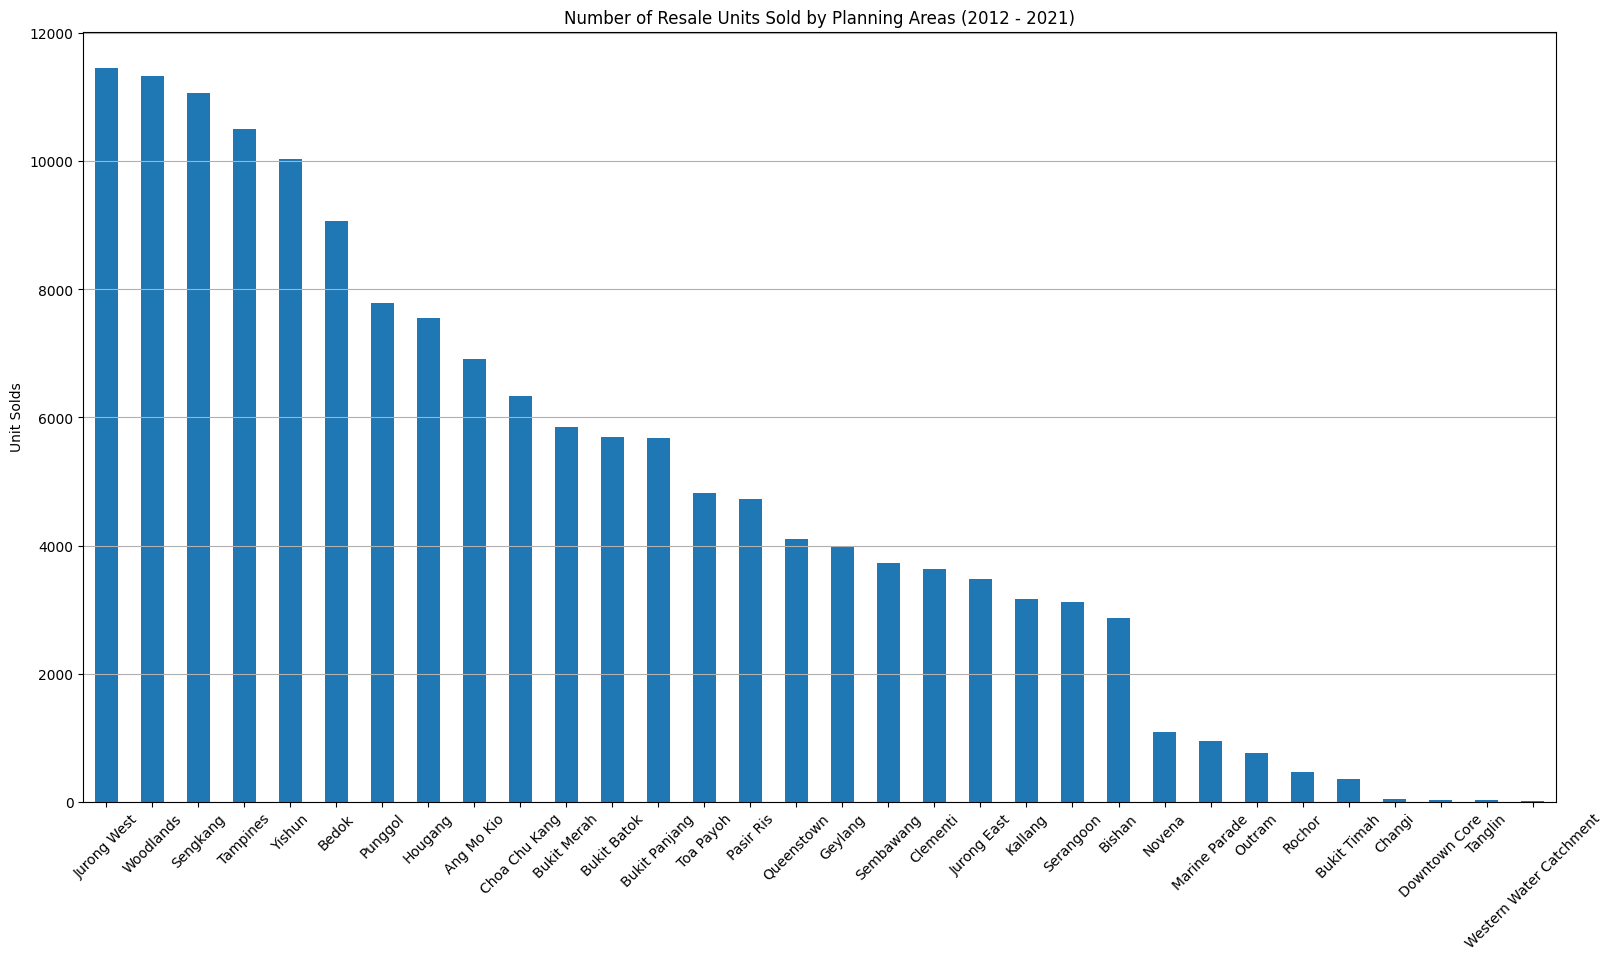

In [17]:
# plot the number of resale units sold over the different planning areas
num_sold_units_planning_area = hdb_raw.groupby(['planning_area'])['id'].count().sort_values(ascending=False)

plt.figure(figsize=(19,10))

num_sold_units_planning_area.plot(kind='bar')
plt.ylabel('Unit Solds')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Number of Resale Units Sold by Planning Areas (2012 - 2021)')

plt.grid(axis='y')

plt.show()

The distribution of resale units sold from 2012 - 2021 shows that more transactions are conducted away from Central area. This might indicate that the houses are more affordable for the general public and that the supply are more abundant in those areas due to Build-To-Order flats reaching their Minimum-Occupation-Period and the resident are selling their home, creating an increased supply. 

### Total number of resale flats sold from 2012 - 2021

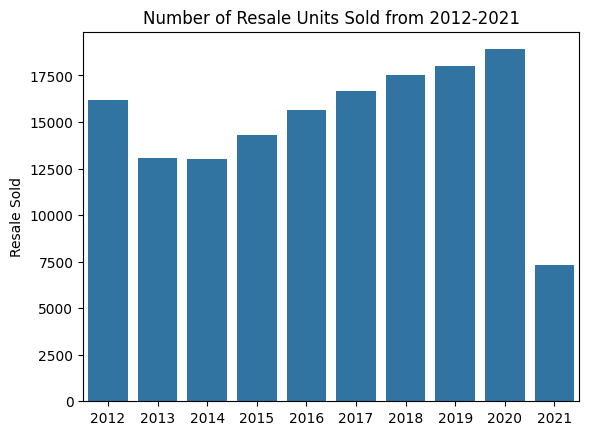

In [18]:
# plot the number of flats sold over the years

flats_sold_years = hdb_raw.groupby(['tranc_year'])['id'].count()

# flats_sold_years.plot(kind='bar')
sns.barplot(x = flats_sold_years.index, y = flats_sold_years.values)

plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Resale Sold')
plt.title('Number of Resale Units Sold from 2012-2021')

plt.show()



There is an observable decrease in resale units transacted between 2012 - 2013  and 2020 - 2021. 

The decrease in resale units sold between from 2012 was due to a cooling measure announced by HDB in October 2012. However, the decrease in number of resale units sold between 2020 and 2021 can be further analysed.

In [19]:
# export to cleaned csv file

hdb_raw.to_csv('../datasets/hdb_cleaned.csv')